In [17]:
"""Script for optimization of a single topology"""
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains

from auto_robot_design.optimization.saver import (
    ProblemSaver, )
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import (
    draw_joint_point, )
from auto_robot_design.optimization.problems import CalculateCriteriaProblemByWeigths, get_optimizing_joints
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory,get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningReward
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability, MeanHeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot

### Parametrization

#### 1) mechanism configuration

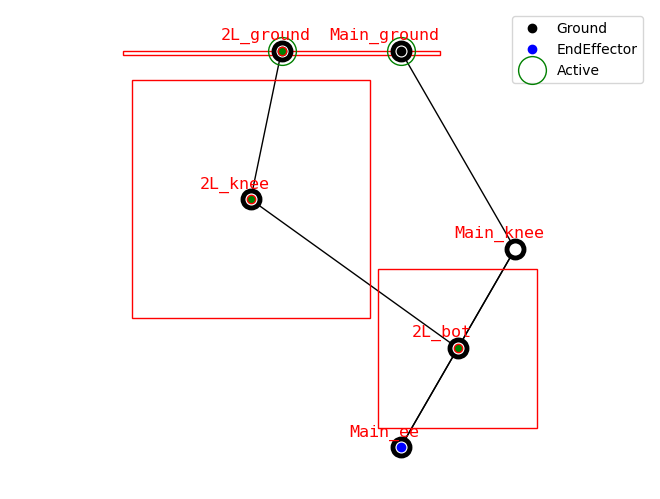

In [18]:
generator = TwoLinkGenerator()
all_graphs = generator.get_standard_set(shift=0.3)
graph, constrain_dict = all_graphs[0]

actuator = TMotor_AK10_9()
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator,thickness=thickness)
draw_joint_point(graph)
visualize_constrains(graph, constrain_dict)

#### 2) set optimization task

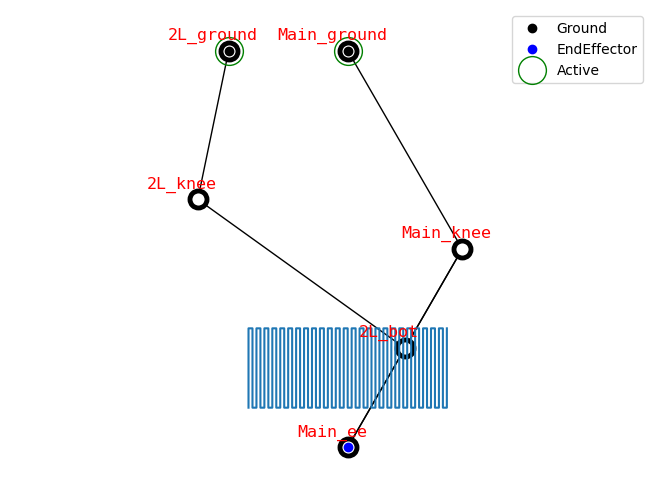

In [19]:
# trajectories
workspace_trajectory = convert_x_y_to_6d_traj_xz(*get_workspace_trajectory([-0.25,-0.9], 0.2, 0.5, 30,50))
# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factorewards_verticalr along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ),
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
acceleration_capability = MinAccelerationCapability(manipulability_key='Manip_Jacobian',
            trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")

heavy_lifting = MeanHeavyLiftingReward(manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")
rewards_vertical = [(PositioningReward(pos_error_key="POS_ERR"), 1),
           (heavy_lifting, 1/16), 
           (acceleration_capability,1)]


vertical_trajectories = [workspace_trajectory]

rewards_and_trajectories = [(rewards_vertical, vertical_trajectories)]

draw_joint_point(graph)

for _, trajectories in rewards_and_trajectories:
    for trajectory in trajectories:
        plt.plot(trajectory[:,0],trajectory[:,2])

#### Calculate rewards for initial graph.

In [20]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder)

crag = CriteriaAggregator(
    dict_point_criteria, dict_trajectory_criteria)

fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
partial_rewards = []
for rewards, trajectories in rewards_and_trajectories:
    max_reward = -float('inf')
    max_partial = None
    best_trajectory = None
    for trajectory_id, trajectory in enumerate(trajectories):
        point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
        current_total = 0
        current_partial = []
        for reward, weight in rewards:
            current_partial.append(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator=actuator)[0])
            current_total += weight*current_partial[-1]
        if current_total > max_reward:
            max_reward = current_total
            max_partial = current_partial
            best_trajectory_id = trajectory_id

    print('Best trajectory id:', best_trajectory_id, 'partial rewards at best trajectory:', max_partial)

Best trajectory id: 0 partial rewards at best trajectory: [0, 0.8892122167028874, 0.3236951]


In [21]:
# activate multiprocessing
N_PROCESS = 16
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

# the result is the dict with key - joint_point, value - tuple of all possible coordinate moves
optimizing_joints = get_optimizing_joints(graph, constrain_dict)

In [22]:
population_size = 32
n_generations = 20

# create the problem for the current optimization
problem = CalculateCriteriaProblemByWeigths(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            crag = crag,
                                            rewards_and_trajectories=rewards_and_trajectories,
                                            elementwise_runner=runner, Actuator = actuator)

saver = ProblemSaver(problem, "test", True)
saver.save_nonmutable()
algorithm = PSO(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed": 1,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })


     1 |       32 |        - |       - |  0.9000 |  2.00000 |  2.00000 | -1.475595E-01 | -1.120894E+00
     2 |       64 |  0.17518 |       3 |  0.5125 |  2.00000 |  2.01684 | -3.972627E-01 | -1.120894E+00
     3 |       96 |  0.13034 |       3 |  0.4834 |  1.99178 |  2.03190 | -6.177653E-01 | -1.171899E+00
     4 |      128 | -1.7E-02 |       3 |  0.3892 |  1.98039 |  2.04229 | -9.279911E-01 | -1.249675E+00
     5 |      160 |  0.09762 |       3 |  0.4622 |  1.96995 |  2.05971 | -1.037813E+00 | -1.294823E+00
     6 |      192 |  0.09149 |       3 |  0.4582 |  1.95618 |  2.06761 | -1.101813E+00 | -1.294823E+00
     7 |      224 |  0.03404 |       3 |  0.4214 |  1.94575 |  2.08081 | -1.139746E+00 | -1.303408E+00
     8 |      256 | -1.0E-02 |       3 |  0.3935 |  1.93386 |  2.08691 | -1.206261E+00 | -1.498505E+00
     9 |      288 | -3.4E-02 |       3 |  0.3787 |  1.92524 |  2.09811 | -1.292015E+00 | -1.560002E+00
    10 |      320 |  0.13415 |       3 |  0.4858 |  1.91516 |  2.10341 | 

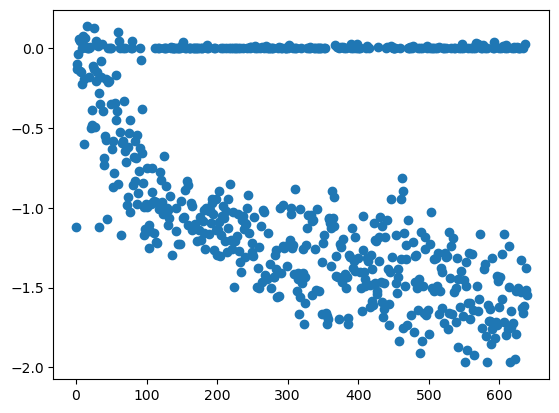

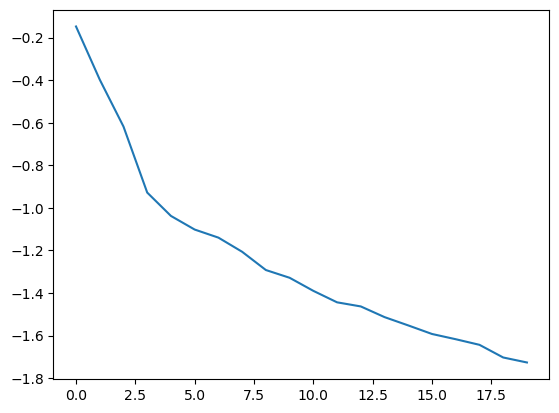

In [23]:
flatten_history = np.array(optimizer.history["F"]).flatten()
history_mean = np.array(optimizer.history["Mean"])
plt.scatter(np.arange(len(flatten_history)),flatten_history)
plt.show()
plt.plot(np.arange(len(history_mean)),history_mean)
plt.show()

In [24]:
worst_id = np.argmax(optimizer.history["F"])
worst_reward = optimizer.history["F"][worst_id]
print('The maximum result in optimization task:', worst_reward.item())

The maximum result in optimization task: 0.1376826124913561


The minimum result in optimization task: [-1.97012834]


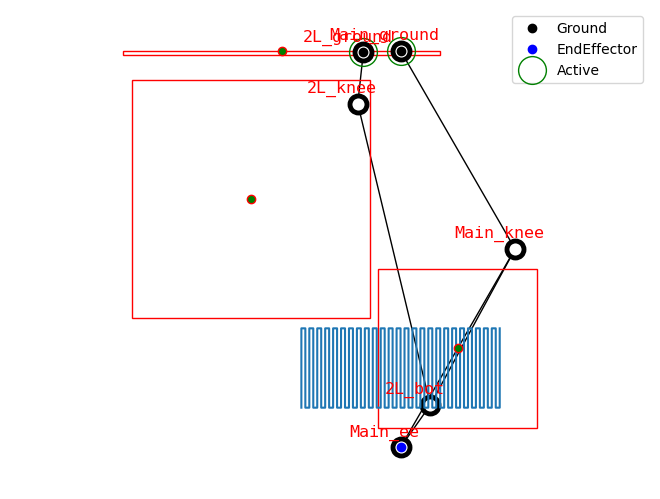

In [25]:
best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]
print("The minimum result in optimization task:", best_reward)

problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

problem.mutate_JP_by_xopt(problem.initial_xopt)
for _, trajectories in rewards_and_trajectories:
    for trajectory in trajectories:
        plt.plot(trajectory[:,0],trajectory[:,2])
visualize_constrains(problem.graph, constrain_dict)


In [26]:
best_reward_decomposition = optimizer.history["Fs"][best_id]
best_reward_decomposition

array([[ 0.        ,  0.        , 17.03632715,  0.9053579 ]])

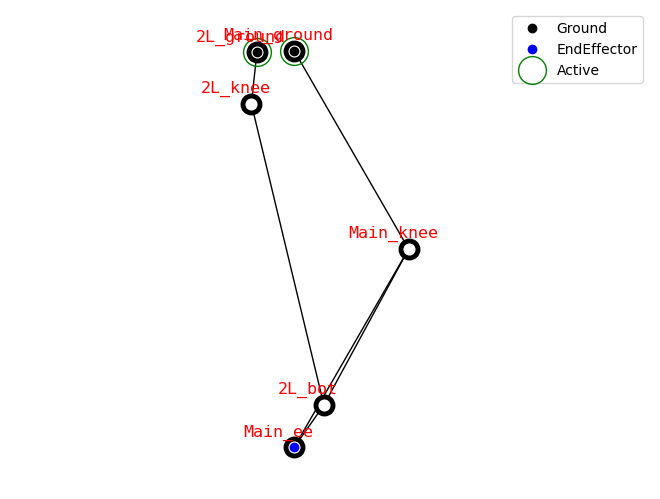

In [27]:
problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

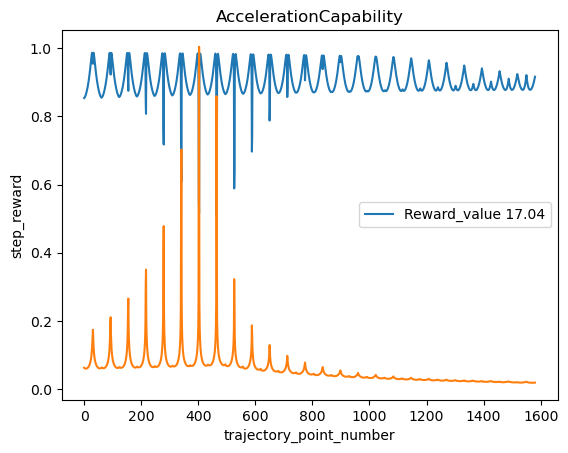

In [38]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)

reward_decomposition = best_reward_decomposition[0]
trajectory_id = int(reward_decomposition[0])
trajectory = rewards_and_trajectories[0][1][trajectory_id]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

reward, reward_list = acceleration_capability.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('AccelerationCapability')
plt.legend([f'Reward_value {round(reward,2)}'])
#plt.show()

reward_decomposition = best_reward_decomposition[0]
trajectory_id = int(reward_decomposition[0])
trajectory = rewards_and_trajectories[0][1][trajectory_id]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

reward, reward_list = heavy_lifting.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector/300)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('AccelerationCapability')
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()

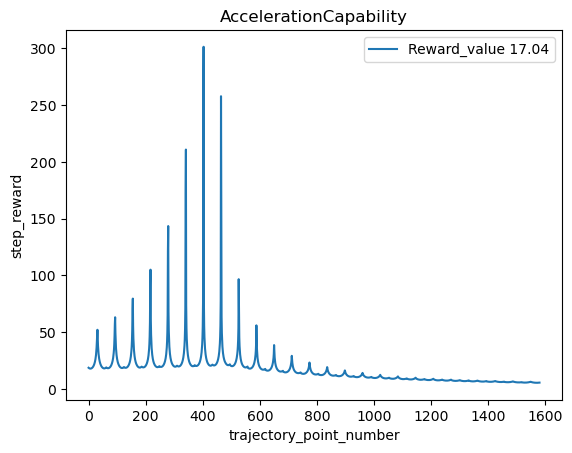

In [35]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)

reward_decomposition = best_reward_decomposition[0]
trajectory_id = int(reward_decomposition[0])
trajectory = rewards_and_trajectories[0][1][trajectory_id]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

reward, reward_list = heavy_lifting.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('AccelerationCapability')
plt.legend([f'Reward_value {round(reward,2)}'])
plt.show()

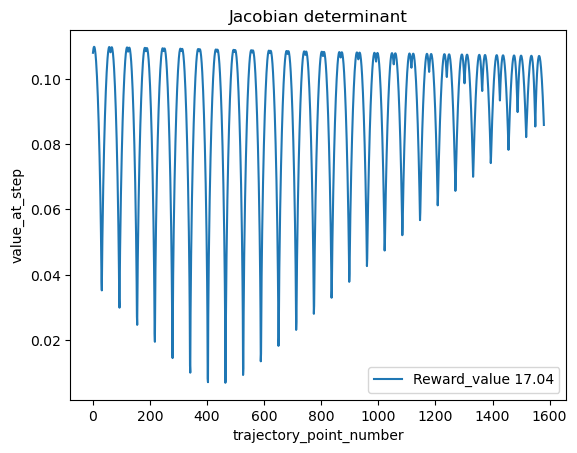

In [40]:
plt.plot(point_criteria_vector["MANIP"])
plt.xlabel('trajectory_point_number')
plt.ylabel('value_at_step')
plt.title('Jacobian determinant')
plt.show()

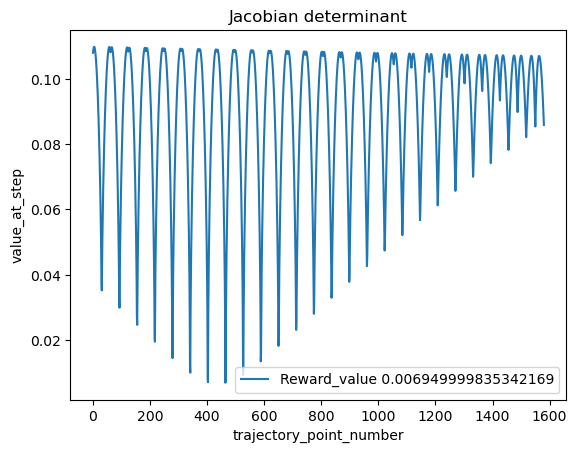

In [47]:
vector = np.linalg.det(point_criteria_vector["Manip_Jacobian"])


plt.plot(vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('value_at_step')
plt.title('Jacobian determinant')
plt.legend([f'Reward_value {round(min(vector),5)}'])
plt.show()

In [29]:
print(len(reward_vector))
reward_vector=np.array(np.split(reward_vector, 51))
for i, _ in enumerate(reward_vector):
    if not i%2:
        reward_vector[i] = np.flip(reward_vector[i])


1581


In [30]:
reward_vector

array([[0.96547014, 0.9839595 , 0.98679364, ..., 0.8557129 , 0.854575  ,
        0.85381514],
       [0.9544738 , 0.98096186, 0.9868323 , ..., 0.8567413 , 0.8555611 ,
        0.85475516],
       [0.94038504, 0.9768671 , 0.9863124 , ..., 0.8577342 , 0.85651827,
        0.855673  ],
       ...,
       [0.9242985 , 0.91946256, 0.9148873 , ..., 0.8980085 , 0.9036934 ,
        0.91048515],
       [0.9203169 , 0.9157402 , 0.9114249 , ..., 0.9016632 , 0.9079741 ,
        0.9154867 ],
       [0.91644543, 0.9121318 , 0.90807736, ..., 0.90578353, 0.91278875,
        0.9210995 ]], dtype=float32)

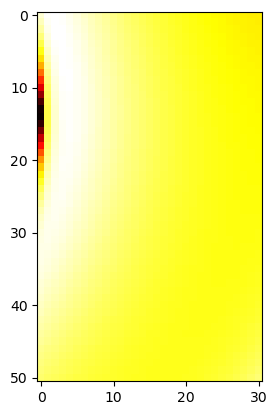

In [31]:
plt.imshow(reward_vector, cmap='hot', interpolation='nearest')
plt.show()


<Axes: >

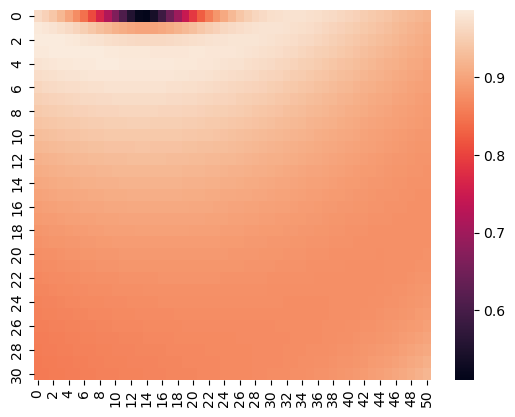

In [32]:
import seaborn as sns
reward_vector = reward_vector.T
sns.heatmap(reward_vector)